<a href="https://colab.research.google.com/github/vishvas-chauhan/First_Repository/blob/master/4_Fresh_Timeseries_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multivariate LSTM Time Series

In [ ]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator 
import matplotlib 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
matplotlib.rcParams['figure.figsize']= (10,8)
matplotlib.rcParams['axes.grid']=False

In [ ]:
#upload file
from google.colab import files
f=files.upload()

Saving Webstore_Sales_Report_Page 2_Time series (1).csv to Webstore_Sales_Report_Page 2_Time series (1) (1).csv


In [ ]:
#read data

# Importing Training Set
dataset_train = pd.read_csv(r'Webstore_Sales_Report_Page 2_Time series (1).csv')

In [ ]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    859 non-null    datetime64[ns]
 1   Users   859 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.5 KB


In [ ]:
dataset_train.head(3)

,Date,Users
0,1/1/2019,191
1,1/2/2019,246
2,1/3/2019,302


In [ ]:
dataset_train['Date']= pd.to_datetime(dataset_train['Date'],infer_datetime_format=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f275b198250>],
      dtype=object)

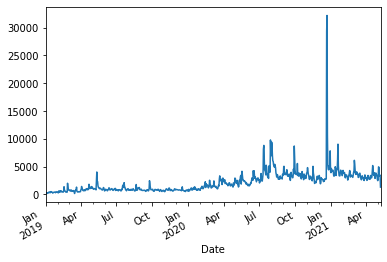

In [ ]:
dataset_train.set_index('Date')['Users'].plot(subplots=True)

In [ ]:
df=dataset_train[['Users']]

In [ ]:
df.describe()

,Users
count,859.000000
mean,2157.271246
std,2086.722477
min,166.000000
25%,817.500000
50%,1565.000000
75%,3163.000000
max,32191.000000


In [ ]:
#scaled data between 0 and 1
scaler= MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [ ]:
#checking top 3 values of array
data_scaled[0:4]

array([[0.00078064],
       [0.00249805],
       [0.00424668],
       [0.0037783 ]])

In [ ]:
#total features in the dataset you want to train on, here is only one so target is also 1
features = data_scaled
target=data_scaled[:,0]

In [ ]:
TimeseriesGenerator(features,target,length = 2, sampling_rate=1,batch_size=1)[0]

(array([[[0.00078064],
         [0.00249805]]]), array([0.00424668]))

In [ ]:
x_train, x_test, y_train,y_test= train_test_split(features,target,test_size=0.20,random_state=123,shuffle=False)

In [ ]:
x_train.shape, x_test.shape

((687, 1), (172, 1))

In [ ]:
#win_length= total rows groups
win_length= 60
batch_size= 20
num_features=1
train_generator = TimeseriesGenerator(x_train,y_train,length=win_length, sampling_rate=1,batch_size= batch_size)
test_generator = TimeseriesGenerator(x_test,y_test,length=win_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
train_generator[0]

(array([[[0.00078064],
         [0.00249805],
         [0.00424668],
         ...,
         [0.03703357],
         [0.02273224],
         [0.01873536]],
 
        [[0.00249805],
         [0.00424668],
         [0.0037783 ],
         ...,
         [0.02273224],
         [0.01873536],
         [0.01992194]],
 
        [[0.00424668],
         [0.0037783 ],
         [0.0028103 ],
         ...,
         [0.01873536],
         [0.01992194],
         [0.01907884]],
 
        ...,
 
        [[0.00640125],
         [0.00215457],
         [0.0040281 ],
         ...,
         [0.        ],
         [0.01027322],
         [0.01505074]],
 
        [[0.00215457],
         [0.0040281 ],
         [0.00577674],
         ...,
         [0.01027322],
         [0.01505074],
         [0.01982826]],
 
        [[0.0040281 ],
         [0.00577674],
         [0.00674473],
         ...,
         [0.01505074],
         [0.01982826],
         [0.01889149]]]),
 array([0.01992194, 0.01907884, 0.01654957, 0.01330211,

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(win_length,num_features),return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 60, 128)           66560     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 60, 128)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 60, 128)           131584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 60, 128)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)               

In [ ]:
early_stopping= tf.keras.callbacks.EarlyStopping(monitor='Val_loss', patience= 2, mode= 'min')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit_generator(train_generator,epochs=20,
                              validation_data= test_generator,
                              shuffle= False,
                              callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
32/32 [==============================] - 10s 179ms/step - loss: 4.0696e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0017 - val_mean_absolute_error: 0.0316
Epoch 2/20
32/32 [==============================] - 5s 148ms/step - loss: 0.0011 - mean_absolute_error: 0.0240 - val_loss: 0.0016 - val_mean_absolute_error: 0.0300
Epoch 3/20
32/32 [==============================] - 5s 151ms/step - loss: 0.0013 - mean_absolute_error: 0.0268 - val_loss: 7.7769e-04 - val_mean_absolute_error: 0.0192
Epoch 4/20
32/32 [==============================] - 5s 149ms/step - loss: 0.0024 - mean_absolute_error: 0.0364 - val_loss: 7.8328e-04 - val_mean_absolute_error: 0.0174
Epoch 5/20
32/32 [==============================] - 5s 148ms/step - loss: 0.0022 - mean_absolute_error: 0.0351 - val_loss: 9.1361e-04 - val_mean_absolute_error: 0.0227
Epoch 6/20
32/32 [==============================] - 5s 151ms/step - loss: 0.0031 - mean_absolute_error: 0.0427 - val_loss: 8.3337e-04 - val_mean_absolute_error: 0.

In [ ]:
model.evaluate_generator(test_generator,verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.0009440263966098428, 0.02452073059976101]

In [ ]:
predictions= model.predict(test_generator)

In [ ]:
df_pred= pd.concat([pd.DataFrame(predictions),pd.DataFrame(x_test[:,:][win_length:])],axis=1)

In [ ]:
df_pred

,0,0
0,0.137304,0.134801
1,0.137775,0.187385
2,0.140430,0.277158
3,0.148114,0.155504
4,0.155374,0.120999
...,...,...
107,0.112611,0.146573
108,0.114788,0.099141
109,0.116872,0.104731
110,0.118506,0.101452


In [ ]:
rev_trans= scaler.inverse_transform(df_pred)

In [ ]:
df_final= df[predictions.shape[0]*-1:]

In [ ]:
df_final.count()

Users    112
dtype: int64

In [ ]:
df_final['predict users']= rev_trans[:,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_final

,Users,predict users
747,4483,4563.167060
748,6167,4578.241160
749,9042,4663.263224
750,5146,4909.337831
751,4041,5141.844889
...,...,...
854,4860,3772.367140
855,3341,3842.091293
856,3520,3908.821909
857,3415,3961.143179


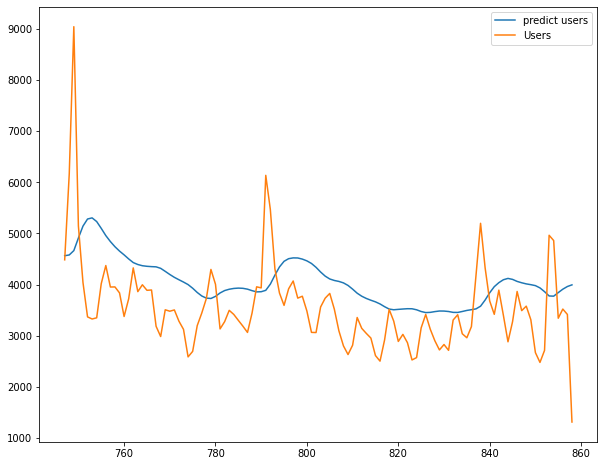

In [ ]:
df_final[['predict users','Users']].plot()

In [ ]:


# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
#datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (859, 2)
All timestamps == 859
Featured selected: ['Users']


## Big Query Arima model

In [ ]:
#standardSQL first query
SELECT
 PARSE_TIMESTAMP("%Y%m%d", date) AS parsed_date,
 SUM(totals.visits) AS total_visits
FROM
 `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY date

#if your data is already sorted
SELECT
 Date AS parsed_date,
 Users AS total_visits
FROM
 `tab.table*`

In [ ]:
#standardSQL
CREATE OR REPLACE MODEL bqml_tutorial.ga_arima_model
OPTIONS
 (model_type = 'ARIMA_PLUS',
  time_series_timestamp_col = 'parsed_date',
  time_series_data_col = 'total_visits',
  auto_arima = TRUE,
  data_frequency = 'AUTO_FREQUENCY',
  decompose_time_series = TRUE
) AS
SELECT
 PARSE_TIMESTAMP("%Y%m%d", date) AS parsed_date,
 SUM(totals.visits) AS total_visits
FROM
 `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY date

In [ ]:
#standardSQL
SELECT
 *
FROM
 ML.ARIMA_EVALUATE(MODEL bqml_tutorial.ga_arima_model)

In [ ]:
#standardSQL
SELECT
 *
FROM
 ML.ARIMA_COEFFICIENTS(MODEL bqml_tutorial.ga_arima_model)

In [ ]:
#standardSQL
SELECT
 *
FROM
 ML.FORECAST(MODEL bqml_tutorial.ga_arima_model,
             STRUCT(30 AS horizon, 0.8 AS confidence_level))

In [ ]:
#standardSQL and predict
SELECT
 *
FROM
 ML.EXPLAIN_FORECAST(MODEL bqml_tutorial.ga_arima_model,
                     STRUCT(30 AS horizon, 0.8 AS confidence_level))

## Multivariate LSTM2

In [ ]:

# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [ ]:
dataset_train = pd.read_csv(r'Webstore_Sales_Report_Page 2_Time series (1).csv')

In [ ]:
dataset_train['Date']=pd.to_datetime(dataset_train['Date'])

In [ ]:
datelist_train= list(dataset_train['Date'])

In [ ]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
#datelist_train = list(dataset_train['Date'])
#datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (859, 2)
All timestamps == 859
Featured selected: ['Users']


In [ ]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set[0:2]

Shape of training set == (859, 1).


array([[191.],
       [246.]])

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-9.42826264e-01],
       [-9.16453787e-01],
       [-8.89601809e-01],
       [-8.96794303e-01],
       [-9.11658791e-01],
       [-9.45703262e-01],
       [-9.01589299e-01],
       [-8.93917306e-01],
       [-8.45487847e-01],
       [-8.16238371e-01],
       [-8.40213351e-01],
       [-8.95835304e-01],
       [-8.65147330e-01],
       [-7.95140389e-01],
       [-8.46446846e-01],
       [-7.95619889e-01],
       [-8.38774852e-01],
       [-8.56516337e-01],
       [-9.21728282e-01],
       [-8.92958306e-01],
       [-8.66106329e-01],
       [-8.51241842e-01],
       [-8.26787362e-01],
       [-8.41651850e-01],
       [-8.52680341e-01],
       [-8.90081309e-01],
       [-8.27266862e-01],
       [-8.45008347e-01],
       [-8.32541358e-01],
       [-7.96099388e-01],
       [-8.16238371e-01],
       [-8.55557338e-01],
       [-8.99191801e-01],
       [-8.83847814e-01],
       [-7.19858953e-01],
       [-8.42610849e-01],
       [-7.89865894e-01],
       [-7.84111899e-01],
       [-7.2

In [ ]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (710, 90, 0).
y_train shape == (710, 1).


In [ ]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [ ]:

# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
3/3 [==============================] - 5s 914ms/step - loss: 0.5358 - val_loss: 3.8103

Epoch 00001: val_loss improved from inf to 3.81027, saving model to weights.h5
Epoch 2/30
3/3 [==============================] - 1s 204ms/step - loss: 0.5088 - val_loss: 3.4774

Epoch 00002: val_loss improved from 3.81027 to 3.47739, saving model to weights.h5
Epoch 3/30
3/3 [==============================] - 1s 200ms/step - loss: 0.5048 - val_loss: 3.6585

Epoch 00003: val_loss did not improve from 3.47739
Epoch 4/30
3/3 [==============================] - 1s 201ms/step - loss: 0.5084 - val_loss: 3.6880

Epoch 00004: val_loss did not improve from 3.47739
Epoch 5/30
3/3 [==============================] - 1s 192ms/step - loss: 0.4870 - val_loss: 3.6600

Epoch 00005: val_loss did not improve from 3.47739
Epoch 6/30
3/3 [==============================] - 1s 207ms/step - loss: 0.4825 - val_loss: 3.5880

Epoch 00006: val_loss did not improve from 3.47739
Epoch 7/30
3/3 [========================

In [ ]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [ ]:
#7 may is last date

# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train , periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

TypeError: ignored

In [ ]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [ ]:
predictions_future[0:3]

array([[-0.03224213],
       [-0.03224213],
       [-0.03224213]], dtype=float32)

In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Users']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Users']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Users
2019-08-28,2048.284424
2019-08-29,2048.284424
2019-08-30,2048.284424


## Arima Python

In [ ]:
df= pd.read_csv(r'Webstore_Sales_Report_Page 2_Time series (1) (1).csv',index_col='Date',parse_dates=True)

In [ ]:
!pip install pmdarima

In [ ]:
#check for stationarity 
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
  dftest=adfuller(dataset,autolag = 'AIC')
  print("1. ADF :", dftest[0])
  print("2. p-value :", dftest[1])
  print("3. num of lags :", dftest[2])
  print("4. n of oberservations used for adf regression and critical value calculation :", dftest[3])
  print("5. critical value :")
  for key, val in dftest[4].items():
    print("\t",key, ": ",val)

In [ ]:
ad_test(df['Users'])

1. ADF : -3.298377827933395
2. p-value : 0.014951141527384457
3. num of lags : 12
4. n of oberservations used for adf regression and critical value calculation : 846
5. critical value :
	 1% :  -3.4381032536542913
	 5% :  -2.8649624121419746
	 10% :  -2.5685923644574107


In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [ ]:
stepwise_fit= auto_arima(df['Users'],trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14506.943, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14786.253, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14785.341, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14774.272, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14784.254, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14504.944, Time=1.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14537.084, Time=0.82 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14719.304, Time=1.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14506.942, Time=1.66 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14507.936, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14556.117, Time=1.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14508.507, Time=1.91 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=14503.923, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14536.325, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0

In [ ]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  859
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -7247.962
Date:                Mon, 10 May 2021   AIC                          14503.923
Time:                        13:59:31   BIC                          14522.942
Sample:                             0   HQIC                         14511.205
                                - 859                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2935      0.019     15.497      0.000       0.256       0.331
ma.L1         -0.3511      0.019    -18.432      0.000      -0.388      -0.314
ma.L2         -0.5824      0.011    -55.449      0.000      -0.603      -0.562
sigma2      1.271e+06   5506.406    230.814      0.000    1.26e+06    1.28e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           4448604.18
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              39.55   Skew:                            15.35
Prob(H) (two-sided):                  0.00   Kurtosis:                       354.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(859, 1)
(829, 1) (30, 1)


In [ ]:
model= ARIMA(train['Users'],order=(1,1,2) )
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Users   No. Observations:                  828
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -7004.234
Method:                       css-mle   S.D. of innovations           1140.400
Date:                Mon, 10 May 2021   AIC                          14018.467
Time:                        13:59:37   BIC                          14042.062
Sample:                    01-02-2019   HQIC                         14027.517
                         - 04-08-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.7311      3.499      1.066      0.286      -3.128      10.590
ar.L1.D.Users     0.2994      0.048      6.229      0.000       0.205       0.394
ma.L1.D.Users    -0.3579      0.040     -8.850      0.000      -0.437      -0.279
ma.L2.D.Users    -0.5822      0.034    -17.109      0.000      -0.649      -0.516
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.3398           +0.0000j            3.3398            0.0000
MA.1            1.0387           +0.0000j            1.0387            0.0000
MA.2           -1.6536           +0.0000j            1.6536            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
#make prediction on test set
start = len(train)
end= len(train)+len(test)-1
print('startlen=',start)
print('endlen=',end)
predict= model.predict(start=start,end=end,typ='levels')

predict.index=df.index[start:end+1]


startlen= 829
endlen= 858


In [ ]:
predict.index= pd.to_datetime(predict.index)

In [ ]:
predict

Date
2021-04-09    3109.054567
2021-04-10    3334.012354
2021-04-11    3403.982247
2021-04-12    3427.546308
2021-04-13    3437.215727
2021-04-14    3442.724871
2021-04-15    3446.988362
2021-04-16    3450.878885
2021-04-17    3454.657735
2021-04-18    3458.403149
2021-04-19    3462.138552
2021-04-20    3465.870957
2021-04-21    3469.602464
2021-04-22    3473.333702
2021-04-23    3477.064861
2021-04-24    3480.795995
2021-04-25    3484.527121
2021-04-26    3488.258246
2021-04-27    3491.989370
2021-04-28    3495.720494
2021-04-29    3499.451618
2021-04-30    3503.182741
2021-05-01    3506.913865
2021-05-02    3510.644989
2021-05-03    3514.376113
2021-05-04    3518.107236
2021-05-05    3521.838360
2021-05-06    3525.569484
2021-05-07    3529.300608
2021-05-08    3533.031731
dtype: float64

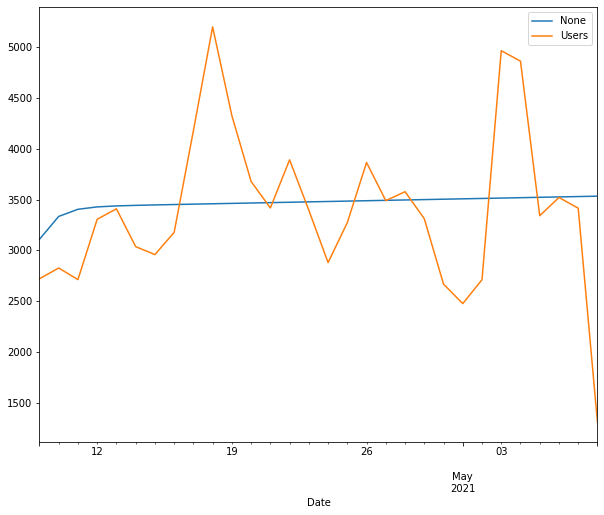

In [ ]:
predict.plot(legend=True)
test['Users'].plot(legend=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(predict,test['Total net sales']))
print(rmse)

In [ ]:
model2=ARIMA(df['Total net sales'],order=(0,1,0))
model2=model2.fit()
df.tail()

In [ ]:
index_future_dates=pd.date_range(start='2021-04-28',end='2021-05-28')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('Arima predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)